# 测试网络

In [8]:
from __future__ import print_function
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from six.moves import range
from RNNCell_diy import diyLSTMCell
from six.moves import cPickle as pickle

%matplotlib inline

读取训练数据

In [9]:
pfile = './concat_image_valid_test_data.pickle'
with open(pfile, "rb") as f:
    valid_test_data = pickle.load(f)
test_dataset = valid_test_data["test_dataset"]
test_dataset.shape = test_dataset.shape + (1,)
test_labels = valid_test_data["test_labels"]

In [10]:
cdic = {"a":0, "b":1, "c":2, "d":3, "e":4, "f":5, "g":6, "h":7, "i":8, "j":9, " ":10}
cdic_r = {}
for key, value in cdic.items():
    cdic_r[value] = key

In [11]:
image_size_h = 56
image_size_w = 112
num_channels = 1

网络结构

In [12]:
kernel_size = 5
pooling_size = 2
channels_one = 12
channels_two = 32
hidden1_size = 300
hidden2_size = 260
rnn_num_nodes = 260
rnn_num_layers = 3


graph = tf.Graph()
with graph.as_default():
    #input data
    tf_test_dataset = tf.placeholder(tf.float32,shape=(1, image_size_h, image_size_w, num_channels))
#     tf_rnn_input = tf.placeholder(tf.int32,shape=[1])
    
    #variables
    layer_weight1 = tf.Variable(tf.truncated_normal([kernel_size, kernel_size, num_channels, channels_one],stddev=0.1))
    layer_biases1 = tf.Variable(tf.zeros([channels_one]), name="bias1")
    
    layer_weight3 = tf.Variable(tf.truncated_normal([kernel_size, kernel_size, channels_one, channels_two], stddev=0.1))
    layer_biases3 = tf.Variable(tf.constant(1.0, shape=[channels_two]), name="bias3")
    
    neuron_num = ((((image_size_h-pooling_size)//pooling_size+1-kernel_size+1-pooling_size)//pooling_size+1)**2)*channels_two
    layer_weight5 = tf.Variable(tf.truncated_normal([neuron_num, hidden1_size], stddev=0.1))
    layer_biases5 = tf.Variable(tf.constant(1.0, shape=[hidden1_size]), name="bias5")
    
    layer_weight6 = tf.Variable(tf.truncated_normal([hidden1_size, hidden2_size], stddev=0.1))
    layer_biases6 = tf.Variable(tf.constant(1.0, shape=[hidden2_size]), name="bias6")
    
    # Classifier weights and biases.
    s_weight = tf.Variable(tf.truncated_normal([hidden2_size, max_time_step], stddev=0.1))
    s_biases = tf.Variable(tf.constant(1.0, shape=[max_time_step]), name="s_bias")
    
    c1_weight = tf.Variable(tf.truncated_normal([hidden2_size, len(cdic)], stddev=0.1))
    c1_biases = tf.Variable(tf.constant(1.0, shape=[len(cdic)]), name="c1_bias")
    
    c2_weight = tf.Variable(tf.truncated_normal([hidden2_size, len(cdic)], stddev=0.1))
    c2_biases = tf.Variable(tf.constant(1.0, shape=[len(cdic)]), name="c2_bias")
    
    c3_weight = tf.Variable(tf.truncated_normal([hidden2_size, len(cdic)], stddev=0.1))
    c3_biases = tf.Variable(tf.constant(1.0, shape=[len(cdic)]), name="c3_bias")
    
#     w = tf.Variable(tf.truncated_normal([rnn_num_nodes, len(cdic)], -0.1, 0.1))
#     b = tf.Variable(tf.zeros([len(cdic)]), name="bias_o")
    
    # Model
    def conv_model(data):
        conv = tf.nn.conv2d(data, layer_weight1, [1,1,1,1], padding="SAME")+layer_biases1
        pooling = tf.nn.relu(tf.nn.max_pool(conv, [1,2,4,1], [1,2,4,1], padding="VALID"))
        conv = tf.nn.conv2d(pooling, layer_weight3, [1,1,1,1], padding="VALID")+layer_biases3
        pooling = tf.nn.relu(tf.nn.max_pool(conv, [1,2,2,1], [1,2,2,1], padding="VALID"))
        shape = pooling.get_shape().as_list()
        reshape = tf.reshape(pooling,[shape[0],shape[1]*shape[2]*shape[3]])
        hidden1 = tf.matmul(reshape, layer_weight5)+layer_biases5
        hidden2 = tf.nn.relu(tf.matmul(hidden1, layer_weight6)+layer_biases6)
        return hidden2
            
#     def rnn_model(input_data):

#         cell_list = []
#         for i in range(rnn_num_layers):
#             rnn_cell = diyLSTMCell(rnn_num_nodes)
#             cell_list.append(rnn_cell)
#         rnn_cells = tf.contrib.rnn.MultiRNNCell(cell_list)
#         with tf.variable_scope("saved_state"):
#             saved_output = tf.get_variable("saved_output", [1, rnn_cells.output_size], initializer=tf.constant_initializer(0.0),
#                                            trainable=False)
#             saved_state_tuple = tuple([tf.get_variable("saved_state_%d"%i, [1, rnn_cells.state_size[i]], 
#                                             initializer=tf.constant_initializer(0.0),
#                                             trainable=False) for i in range(len(rnn_cells.state_size))])
#         with tf.variable_scope("rnn"): 
#             rnn_output, rnn_state = rnn_cells(input_data, saved_state_tuple)
#         return rnn_output, rnn_state, rnn_cells
    
#     def update_state_and_out_op(state_variables, new_states, output_variable, new_output):
#         update_ops = []
#         for state_variable, new_state in zip(state_variables, new_states):
#             # Assign the new state to the state variables on this layer
#             update_ops.append(state_variable.assign(new_state))
#         # Return a tuple in order to combine all update_ops into a single operation.
#         # The tuple's actual value should not be used.
#         update_ops.append(output_variable.assign(new_output))
#         return tf.tuple(update_ops)

    conv_out = conv_model(tf_test_dataset)
#     rnn_output, rnn_state, rnn_cells = rnn_model(conv_out)
#     logits = tf.matmul(rnn_output, w) + b
    
#     tf.get_variable_scope().reuse_variables()
#     rnn_output2, rnn_state2, rnn_cells = rnn_model(tf.one_hot(tf_rnn_input, hidden2_size))
#     logits2 = tf.matmul(rnn_output2, w) + b
    
    
    
#     with tf.variable_scope("saved_state"):
#         saved_output = tf.get_variable("saved_output")
#         saved_state_tuple = tuple([tf.get_variable("saved_state_%d"%i) for i in range(len(rnn_cells.state_size))])
    
#     zero_ouput = tf.zeros([1, rnn_cells.output_size])
#     zero_state_init = rnn_cells.zero_state(1,tf.float32)
    
        
    # Predictions for the training, validation, and test data.
#     test_prediction = tf.nn.softmax(logits)
#     test_prediction2 = tf.nn.softmax(logits2)
    
    #update state
#     update_state_and_output = update_state_and_out_op(saved_state_tuple, rnn_state, saved_output, rnn_output)
#     update_state_and_output2 = update_state_and_out_op(saved_state_tuple, rnn_state2, saved_output, rnn_output2)
#     reset_state_and_ouptut = update_state_and_out_op(saved_state_tuple, zero_state_init, saved_output, zero_ouput)

    s_logits = tf.matmul(conv_out, s_weight)+s_biases
    c1_logits = tf.matmul(conv_out, c1_weight)+c1_biases
    c2_logits = tf.matmul(conv_out, c2_weight)+c2_biases
    c3_logits = tf.matmul(conv_out, c3_weight)+c3_biases
    
    test_prediction_s = tf.nn.softmax(s_logits)
    test_prediction1 = tf.nn.softmax(c1_logits)
    test_prediction2 = tf.nn.softmax(c2_logits)
    test_prediction3 = tf.nn.softmax(c3_logits)
    
    #model saver
    saver = tf.train.Saver(tf.trainable_variables())


In [13]:
def logprob(predictions, labels):
  """Log-probability of the true labels in a predicted batch."""
  predictions[predictions < 1e-10] = 1e-10
  return np.sum(np.multiply(labels, -np.log(predictions))) / labels.shape[0]

def chara(prediction):
    return cdic_r[np.argmax(prediction,1)[0]]

def charsq(predictions):
    pass

INFO:tensorflow:Restoring parameters from model2/model.ckpt


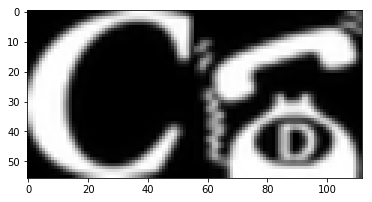

ce 


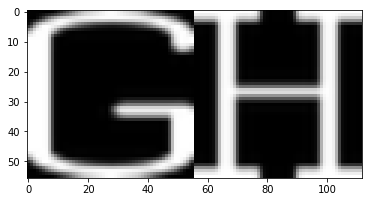

gh 


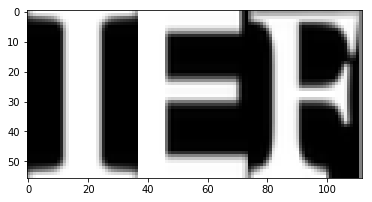

ief


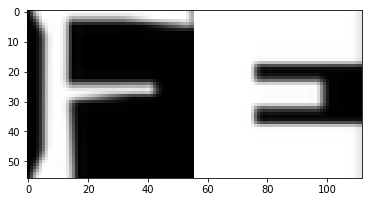

fe 


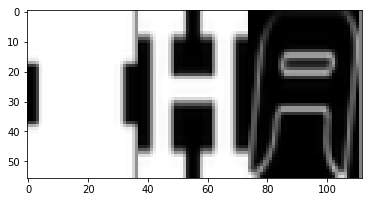

ihh


In [14]:
with tf.Session(graph=graph) as sess:
    tf.global_variables_initializer().run()
    saver.restore(sess,"model2/model.ckpt")
    index = np.random.randint(0,len(test_dataset),5)
    batch_test = test_dataset[index]
    for i in range(5):
        feed_dict = {}
        feed_dict[tf_test_dataset] = batch_test[[i]]
#         prediction,_ = sess.run([test_prediction, update_state_and_output], feed_dict=feed_dict)
#         prediction = sess.run(test_prediction, feed_dict=feed_dict)
#         print(prediction)
#         sentence = chara(prediction)
#         while chara(prediction) != "remain":
#             sentence += chara(prediction)
#             feed_dict = {}
#             feed_dict[tf_rnn_input] = [cdic[chara(prediction)]]
#             prediction,_ = sess.run([test_prediction2,update_state_and_output2], feed_dict=feed_dict)
        prediction1, prediction2, prediction3 = sess.run([test_prediction1, test_prediction2, test_prediction3],feed_dict=feed_dict)
        plt.imshow(batch_test[i].reshape(batch_test[i].shape[:-1]), cmap=plt.cm.gray)
        plt.show()
        print(chara(prediction1)+chara(prediction2)+chara(prediction3))
#         sess.run([reset_state_and_ouptut])
        
        